# Advanced NLP Assignment 2: Transformer-Based SRL Pipeline

## Link to the model:
https://drive.google.com/drive/folders/131Qrbyv_SIQ-TMl8w4N2BghkOIKI_NnG?usp=sharing

A lot of the below code deals with the universal propbank data, and it is the same as the code I have used in Assignment 1.

### 1. Data Cleaning

In [1]:
def preprocess_propbank(file_path):
    """
    Preprocesses the Universal Proposition Bank data from a CoNLL file.
    Extracts only words, predicate IDs, and argument structures.
    Correctly associates each argument structure with its corresponding predicate.

    Args:
        file_path (str): Path to the .conllu file.

    Returns:
        list: A list of dictionaries, where each dictionary represents a preprocessed sentence.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read()

    sentences = data.strip().split("\n\n")  # Each sentence is separated by a blank line
    preprocessed_data = []

    for sentence_block in sentences:
        lines = sentence_block.strip().split("\n")
        words = []
        predicates = {}  # Store predicate index and sense
        sentence_id = "_"
        invalid_word_id = False

        # Extract sentence ID
        for line in lines:
            if line.startswith("# sent_id"):
                sentence_id = line.split(" = ")[1]
                break

        # Filter out comment lines
        lines = [x for x in lines if not x.startswith("#")]

        # Extract words and predicates
        for line_idx, line in enumerate(lines):
            parts = line.split("\t")

            # Ensure the line has at least 10 columns
            if len(parts) < 10:
                continue  

            token_id_str = parts[0]

            # Ignore non-integer token IDs (e.g., "8.1", "_")
            if not token_id_str.isdigit():
                invalid_word_id = True
                continue  

            token_id = int(token_id_str)
            token_form = parts[1]
            predicate_sense = parts[10] if len(parts) > 10 else "_"

            words.append(token_form)  # Collect words of the sentence

            # If it's a predicate, store its index
            if predicate_sense != "_":
                predicates[token_id] = predicate_sense  

        if invalid_word_id:
            continue

        # Extract argument structures for each predicate
        for pred_index, pred_sense in predicates.items():
            arguments = ["O"] * len(words)  # Default all tokens to "O"

            # Find the argument column corresponding to this predicate
            for tok_idx, line in enumerate(lines):
                parts = line.split("\t")

                if len(parts) > 10:  # Ensure argument columns exist
                    # Iterate over all argument columns to find the one with "V" for this predicate
                    for col_idx in range(11, len(parts)):
                        if parts[col_idx] == "V" and tok_idx == pred_index - 1:
                            # This column corresponds to the current predicate
                            for line_idx2, line2 in enumerate(lines):
                                parts2 = line2.split("\t")
                                if len(parts2) > col_idx:
                                    arg_label = parts2[col_idx]
                                    if arg_label != "_":
                                        arguments[line_idx2] = arg_label
                            break  # Stop searching once the correct column is found

            # Ensure the number of arguments matches the number of words
            if len(arguments) != len(words):
                print(f"Mismatch in sentence: {words}")
                continue  # Skip this sentence or handle the mismatch

            preprocessed_data.append({
                "words": words,
                "predicate_id": pred_index,
                "arguments": arguments,
                "sentence_id": sentence_id
            })

    return preprocessed_data

train_file = "data/en_ewt-up-train.conllu"
test_file = "data/en_ewt-up-test.conllu"

preprocessed_train_data = preprocess_propbank(train_file)
preprocessed_test_data = preprocess_propbank(test_file)

In [2]:
with open('preprocessed_train_data.csv', 'w', encoding='utf-8') as f:
    for line in preprocessed_train_data:
        f.write(f"{line}\n")

In [3]:
with open('preprocessed_test_data.csv', 'w', encoding='utf-8') as f:
    for line in preprocessed_test_data:
        f.write(f"{line}\n")

In [4]:
for sentence in preprocessed_train_data:
    assert len(sentence["words"]) == len(sentence["arguments"]), "Mismatch in train data"

for sentence in preprocessed_test_data:
    assert len(sentence["words"]) == len(sentence["arguments"]), "Mismatch in test data"

### 2. Gathering Statistics

In [5]:
def gather_statistics(preprocessed_data):
    """
    Gathers statistics about the preprocessed data.

    Args:
        preprocessed_data (list): List of preprocessed sentences.

    Returns:
        dict: A dictionary containing statistics.
    """
    num_sentences = len(preprocessed_data)
    num_tokens = sum(len(sentence["words"]) for sentence in preprocessed_data)

    return {
        "num_sentences": num_sentences,
        "num_tokens": num_tokens
    }

def gather_raw_statistics(file_path):
    """
    Gathers statistics about the raw CoNLL data before preprocessing.

    Args:
        file_path (str): Path to the CoNLL file.

    Returns:
        dict: A dictionary containing statistics.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read()

    # Split the data into sentences (each sentence is separated by a blank line)
    sentences = data.strip().split("\n\n")
    num_sentences = len(sentences)

    # Count the number of tokens (non-comment lines in each sentence)
    num_tokens = 0
    for sentence in sentences:
        lines = sentence.strip().split("\n")
        # Filter out comment lines (lines starting with "#")
        num_tokens += len([line for line in lines if not line.startswith("#")])

    return {
        "num_sentences": num_sentences,
        "num_tokens": num_tokens
    }

train_raw_stats = gather_raw_statistics("data/en_ewt-up-train.conllu")
test_raw_stats = gather_raw_statistics("data/en_ewt-up-test.conllu")

train_stats = gather_statistics(preprocessed_train_data)
test_stats = gather_statistics(preprocessed_test_data)

print("Train Statistics (Before Preprocessing):", train_raw_stats)
print("Test Statistics (Before Preprocessing):", test_raw_stats)
print("Train Statistics (After Preprocessing):", train_stats)
print("Test Statistics (After Preprocessing):", test_stats)

Train Statistics (Before Preprocessing): {'num_sentences': 12543, 'num_tokens': 204609}
Test Statistics (Before Preprocessing): {'num_sentences': 2077, 'num_tokens': 25097}
Train Statistics (After Preprocessing): {'num_sentences': 40396, 'num_tokens': 1024323}
Test Statistics (After Preprocessing): {'num_sentences': 4863, 'num_tokens': 101518}


### 3. Pre-processing

The below code is where we diverge from Assignment 2. The tokenizer cannot handle string input, it tries to convert our labels like `ARG1` and `V` and `O` to strings and fails to do so. Hence, I decided to create a mapping of argument labels to some argument IDs. That is what I have done in the code below.

In [31]:
# Extract all unique argument labels from the preprocessed data
unique_labels = set()

for example in preprocessed_train_data:
    unique_labels.update(example["arguments"])

# Convert to sorted list and create mapping
unique_labels = sorted(unique_labels)
srl_label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
print("Label mapping:", srl_label_mapping)


Label mapping: {'ARG0': 0, 'ARG1': 1, 'ARG1-DSP': 2, 'ARG2': 3, 'ARG3': 4, 'ARG4': 5, 'ARG5': 6, 'ARGA': 7, 'ARGM-ADJ': 8, 'ARGM-ADV': 9, 'ARGM-CAU': 10, 'ARGM-COM': 11, 'ARGM-CXN': 12, 'ARGM-DIR': 13, 'ARGM-DIS': 14, 'ARGM-EXT': 15, 'ARGM-GOL': 16, 'ARGM-LOC': 17, 'ARGM-LVB': 18, 'ARGM-MNR': 19, 'ARGM-MOD': 20, 'ARGM-NEG': 21, 'ARGM-PRD': 22, 'ARGM-PRP': 23, 'ARGM-PRR': 24, 'ARGM-REC': 25, 'ARGM-TMP': 26, 'C-ARG0': 27, 'C-ARG1': 28, 'C-ARG1-DSP': 29, 'C-ARG2': 30, 'C-ARG3': 31, 'C-ARG4': 32, 'C-ARGM-ADV': 33, 'C-ARGM-COM': 34, 'C-ARGM-CXN': 35, 'C-ARGM-DIR': 36, 'C-ARGM-EXT': 37, 'C-ARGM-GOL': 38, 'C-ARGM-LOC': 39, 'C-ARGM-MNR': 40, 'C-ARGM-PRP': 41, 'C-ARGM-PRR': 42, 'C-ARGM-TMP': 43, 'C-V': 44, 'O': 45, 'R-ARG0': 46, 'R-ARG1': 47, 'R-ARG2': 48, 'R-ARG3': 49, 'R-ARG4': 50, 'R-ARGM-ADV': 51, 'R-ARGM-CAU': 52, 'R-ARGM-COM': 53, 'R-ARGM-DIR': 54, 'R-ARGM-GOL': 55, 'R-ARGM-LOC': 56, 'R-ARGM-MNR': 57, 'R-ARGM-TMP': 58, 'V': 59}


In [33]:
def replace_oov_labels(data, label_mapping, default_label="O"):
    """"Replace labels not found in label_mapping with default_label.
    
    Args:
        data: List of dictionaries containing "arguments" lists
        label_mapping: Dictionary of known labels
        default_label: Label to use for OOV cases (default "O")
    
    Returns:
        Modified data with OOV labels replaced
    """
    for example in data:
        example["arguments"] = [
            label if label in label_mapping else default_label
            for label in example["arguments"]
        ]
    return data

In [34]:
preprocessed_test_data = replace_oov_labels(
    preprocessed_test_data,
    srl_label_mapping,
    default_label="O"
)

In assignment 1, I kept a 1-based predicate_index integer to indicate the predicate in the sentences. However, for a transformer based model, it is better to have a predicate mask, which is full of 0s and has a value of 1 for the index corresponding to the predicate in the token list.

In [62]:
def create_predicate_indicator(words_list, predicate_id):
    """
    Converts 1-based predicate_id to a 0-based indicator list.
    
    Args:
        words_list: List of words in the sentence
        predicate_id: 1-based index of the predicate
        
    Returns:
        List of 0s with a 1 at the predicate position (0-based)
    """
    predicate_indicator = [0] * len(words_list)
    if 1 <= predicate_id <= len(words_list):
        predicate_indicator[predicate_id - 1] = 1  # Convert to 0-based
    return predicate_indicator

We describe the features of the dataset for the datasets library

In [63]:
from datasets import Dataset, DatasetDict, Features, Value, Sequence, ClassLabel

# Defining the features for the Hugging Face dataset.
features = Features({
    'words': Sequence(feature=Value(dtype='string')),
    'predicate': Sequence(feature=Value(dtype='string')),
    'arguments': Sequence(feature=ClassLabel(names=unique_labels)),
})

Here. I have converted our dataset which was a list of dictionaries for each sentence of data, to a datset_dict format. I also applied the create_predicate_indicator function described above, and also, the label_mapping created above, to create a HuggingFace style dataset_dict

In [64]:
def convert_to_dataset(preprocessed_data, label_mapping):
    """
    Converts preprocessed data to Hugging Face Dataset format with integer labels.
    
    Args:
        preprocessed_data: List of dictionaries containing:
            - words: List[str]
            - predicate_id: int 
            - arguments: List[str]
            - sentence_id: str
        label_mapping: Dictionary mapping argument strings to integers
            
    Returns:
        Hugging Face Dataset with:
            - Original string fields
            - argument_ids: List[int] (mapped labels)
    """
    # Convert arguments to integer IDs using provided mapping
    processed_examples = []
    for example in preprocessed_data:
        preds = create_predicate_indicator(example["words"], example["predicate_id"])
        new_example = {
            "words": example["words"],
            "predicate": preds,
            "arguments": [label_mapping[label] for label in example["arguments"]]
        }
        processed_examples.append(new_example)
    
    # Convert to Hugging Face Dataset
    return Dataset.from_list(processed_examples, features=features)



train_dataset = convert_to_dataset(preprocessed_train_data, srl_label_mapping)
test_dataset = convert_to_dataset(preprocessed_test_data, srl_label_mapping)

dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [65]:
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['words', 'predicate', 'arguments'],
        num_rows: 40396
    })
    test: Dataset({
        features: ['words', 'predicate', 'arguments'],
        num_rows: 4863
    })
})


I create a `label_list` to keep track of all the labels occuring in the train datset.

In [66]:
label_list = dataset_dict["train"].features["arguments"].feature.names
label_list

['ARG0',
 'ARG1',
 'ARG1-DSP',
 'ARG2',
 'ARG3',
 'ARG4',
 'ARG5',
 'ARGA',
 'ARGM-ADJ',
 'ARGM-ADV',
 'ARGM-CAU',
 'ARGM-COM',
 'ARGM-CXN',
 'ARGM-DIR',
 'ARGM-DIS',
 'ARGM-EXT',
 'ARGM-GOL',
 'ARGM-LOC',
 'ARGM-LVB',
 'ARGM-MNR',
 'ARGM-MOD',
 'ARGM-NEG',
 'ARGM-PRD',
 'ARGM-PRP',
 'ARGM-PRR',
 'ARGM-REC',
 'ARGM-TMP',
 'C-ARG0',
 'C-ARG1',
 'C-ARG1-DSP',
 'C-ARG2',
 'C-ARG3',
 'C-ARG4',
 'C-ARGM-ADV',
 'C-ARGM-COM',
 'C-ARGM-CXN',
 'C-ARGM-DIR',
 'C-ARGM-EXT',
 'C-ARGM-GOL',
 'C-ARGM-LOC',
 'C-ARGM-MNR',
 'C-ARGM-PRP',
 'C-ARGM-PRR',
 'C-ARGM-TMP',
 'C-V',
 'O',
 'R-ARG0',
 'R-ARG1',
 'R-ARG2',
 'R-ARG3',
 'R-ARG4',
 'R-ARGM-ADV',
 'R-ARGM-CAU',
 'R-ARGM-COM',
 'R-ARGM-DIR',
 'R-ARGM-GOL',
 'R-ARGM-LOC',
 'R-ARGM-MNR',
 'R-ARGM-TMP',
 'V']

An example of how one sentence is stored in the dataset_dict format.

In [67]:
dataset_dict["train"][100]

{'words': ['Al',
  '-',
  'Zaman',
  ':',
  'The',
  'Iraqi',
  'High',
  'Electoral',
  'Commission',
  'on',
  'Friday',
  'denied',
  'a',
  'request',
  'of',
  'the',
  'Debaathification',
  'Commission',
  'to',
  'exclude',
  '51',
  'individuals',
  'from',
  'running',
  'on',
  'party',
  'lists',
  'in',
  'the',
  'Dec.',
  '15',
  'elections',
  'on',
  'grounds',
  'of',
  'having',
  'been',
  'sufficiently',
  'involved',
  'in',
  'Baath',
  'activities',
  'to',
  'warrant',
  'their',
  'being',
  'excluded',
  'from',
  'civil',
  'office',
  '.'],
 'predicate': ['0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'],
 'arguments': [45,
  45,
  45,
  45,
  45,
  45,
  45,

Save the datasetdict object to a file, if I need to recover it later.

In [68]:
dataset_dict.save_to_disk("datasetdict")

Saving the dataset (1/1 shards): 100%|██████████| 4863/4863 [00:00<00:00, 939689.50 examples/s] 


The below function is from the original notebook, and is used to display the dataset in a readable format

In [69]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [70]:
show_random_elements(dataset_dict["train"])

,words,predicate,arguments
0,"[Otherwise, ,, you, can, do, what, you, can, do, in, other, parts, or, Japan, ,, like, shopping, ,, eating, ,, etc, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, V, O, O, O]"
1,"[We, are, running, so, full, tilt, on, TW, that, we, may, not, have, as, much, flexibiltiy, to, manage, this, situation, as, we, expected, ,, but, let, me, know, what, we, can, do, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, V, O, ARG1, O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,"[The, result, will, be, a, dramatic, escalation, in, US, and, civilian, casualties, ,, US, forces, will, be, required, to, bunker, themselves, further, into, their, bases, ,, and, US, forces, will, find, themselves, required, to, fight, the, very, government, they, just, finished, helping, into, power, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ARG2, ARG0, O, O, V, O, ARG1, O]"
3,"[Birds, are, hard, to, gain, trust, with, ,, but, it, 's, lost, so, easily, !]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[O, O, O, O, O, O, O, O, O, ARG1, O, V, O, ARGM-MNR, O]"
4,"[Indian, intelligence, 's, lackluster, performance, in, dealing, with, the, LTTE, is, startling, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[O, O, O, O, ARG1, O, O, O, O, O, V, ARG2, O]"
5,"[It, is, fair, to, say, that, this, creates, an, unprecedented, breeding, ground, for, cruel, dictators, ,, terror, networks, ,, fanaticism, ,, incitement, ,, suicide, murders, and, general, decline, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, V, O, O, O, O, O, O, O]"
6,"[I, called, and, asked, about, the, price, for, hair, updo, and, the, receptionist, or, owner, who, aswered, the, phone, refused, to, tell, me, ,, or, even, just, give, me, an, approximate, price, range, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, O, O, O, O, O, O, O, O, ARG0, O, O, R-ARG0, V, O, ARG1, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
7,"[We, then, called, the, office, and, the, man, we, spoke, to, said, he, 'd, send, someone, out, to, look, at, it, but, could, n't, promise, when, -, two, weeks, came, and, went, and, we, heard, nothing, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, O, O, O, O, O, O, O, O, ARG0, O, O, O, O, O, O, O, O, O, ARGM-MOD, ARGM-NEG, V, ARGM-TMP, O, O, O, O, O, O, O, O, O, O, O]"
8,"[50, -, Percentage, decline, in, Environmental, Protection, Agency, enforcement, actions, against, polluters, under, Bush, 's, watch, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, O, O, O, ARG0, ARGM-MNR, V, O, ARGM-GOL, O, O, O, O, O]"
9,"[The, reports, say, she, is, suspected, of, having, been, a, member, of, Al, Qaeda, 's, "", Chemical, Wire, Group, ., ""]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[O, V, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"


### Data Preparation

I have used the recommended `distilbert-base-uncased` pretrained model.
To preprocess/prepare the input data to feed to a transformer based model such as `distilbert-base-uncased`, I decided to use the method used in [Simple BERT Models  for Relation Extraction and Semantic Role Labeling by Peng Shi and Jimmy Lin](https://arxiv.org/pdf/1904.05255), which is to append the predicate at the end of the tokenized sentence. The tokenizer adds the [CLS] and [SEP] at the start and end of the sentence respectively. So we want to append our predicate after the [SEP] and then another [SEP] after the predicate. An example of it is given below.

In [71]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [79]:
example = dataset_dict["train"][17]
print(example)

{'words': ['The', 'third', 'was', 'being', 'run', 'by', 'the', 'head', 'of', 'an', 'investment', 'firm', '.'], 'predicate': ['0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], 'arguments': [45, 45, 59, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]}


In [86]:
tokens = example["words"]
predicate = example["predicate"]
predicate_index = predicate.index('1') if "1" in predicate else None

tokenized_input = tokenizer(tokens, [str(tokens[predicate_index])], is_split_into_words=True,  add_special_tokens=True)

tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)
print(tokenized_input["input_ids"])

['[CLS]', 'the', 'third', 'was', 'being', 'run', 'by', 'the', 'head', 'of', 'an', 'investment', 'firm', '.', '[SEP]', 'was', '[SEP]']
[101, 1996, 2353, 2001, 2108, 2448, 2011, 1996, 2132, 1997, 2019, 5211, 3813, 1012, 102, 2001, 102]


We have tweaked the `tokenize_and_align_labels()` method  to deal with the extra tokens created by the tokenization as shown above. We deal with them in the function below by giving a -100 label value to the extra tokens added like [CLS] and [SEP]; and by taking the first value of a subword, incase the tokenizer creates subwords.

In [87]:
label_all_tokens = True

In [88]:
def tokenize_and_align_labels(examples):
    """Preprocesses raw text input for SRL task with predicate-aware encoding.
    Args:
        examples: Batch containing:
            - tokens: List of word tokens
            - predicate_id: 1-based index of predicate
            - arguments: List of argument labels
    Returns:
        Dictionary with tokenized inputs and aligned labels
    """
    tokenized_inputs = {
        "input_ids": [],
        "attention_mask": [],
        "labels": []
    }

    for words, pred_id, args in zip(examples["words"], 
                                  examples["predicate"], 
                                  examples["arguments"]):
        
        # Convert 1-based predicate index to 0-based and get predicate word
        pred_idx = pred_id.index('1')
        predicate_word = words[pred_idx]

        # Tokenize with predicate-aware formatting
        tokenized = tokenizer(
            words, 
            [predicate_word],  # Add predicate as second sequence
            is_split_into_words=True,
            add_special_tokens=True,
        )

        # Align labels with tokenized words
        word_ids = tokenized.word_ids()  # Map tokens to original words
        aligned_labels = []
        previous_word_idx = None
        
        for word_idx in word_ids:
            # Special tokens get -100
            if word_idx is None:
                aligned_labels.append(-100)
            # Only label the first token of each word
            elif word_idx != previous_word_idx:
                aligned_labels.append(args[word_idx])
            else:
                aligned_labels.append(args[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        tokenized_inputs["input_ids"].append(tokenized["input_ids"])
        tokenized_inputs["attention_mask"].append(tokenized["attention_mask"])
        tokenized_inputs["labels"].append(aligned_labels)

    return tokenized_inputs

In [29]:
sentence = ["Pia", "asked", "Luis", "to", "write", "this", "sentence", "."]
predicate_id = 5  # "write" (1-based index)
arguments = ["O", "O", "O", "O", "V", "ARG1", "ARG1", "O"]

We apply the `tokenize_and_align_labels()` function defined above to the entire dataset_dict object by using the map function.

In [89]:
tokenized_datasets = dataset_dict.map(
    tokenize_and_align_labels,
    batched=True
)

Map: 100%|██████████| 4863/4863 [00:00<00:00, 7443.45 examples/s]


## Remove arguments and argument_ids 

In [90]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['words', 'predicate', 'arguments', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 40396
    })
    test: Dataset({
        features: ['words', 'predicate', 'arguments', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4863
    })
})


We need to remove the gold labels "arguments" before passing it to the model. 

In [106]:
# Remove 'arguments' column from both train and test sets
tokenized_datasets = tokenized_datasets.remove_columns('arguments')

In [113]:
# Verify the columns were removed
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['words', 'predicate', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 40396
    })
    test: Dataset({
        features: ['words', 'predicate', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4863
    })
})


An example of the input after tokenization, just before feeding it to the model:

In [108]:
tokenized_datasets["train"][1]

{'words': ['[',
  'This',
  'killing',
  'of',
  'a',
  'respected',
  'cleric',
  'will',
  'be',
  'causing',
  'us',
  'trouble',
  'for',
  'years',
  'to',
  'come',
  '.',
  ']'],
 'predicate': ['0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'],
 'input_ids': [101,
  1031,
  2023,
  4288,
  1997,
  1037,
  9768,
  29307,
  2097,
  2022,
  4786,
  2149,
  4390,
  2005,
  2086,
  2000,
  2272,
  1012,
  1033,
  102,
  4288,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [-100,
  45,
  45,
  59,
  45,
  45,
  45,
  1,
  45,
  45,
  45,
  45,
  45,
  45,
  45,
  45,
  45,
  45,
  45,
  -100,
  45,
  -100]}

### 4. Fine-tuning the model

In [109]:
import numpy as np

In [110]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_list))

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [111]:
from transformers import set_seed

# Set random seed!
SEED = 0
set_seed(SEED)

task = "srl"
batch_size = 16

model_name = "distilbert-base-uncased"
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

In [114]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [115]:
from evaluate import load

metric = load("seqeval")

In [116]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [117]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_249183/1234220955.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Training the model

In [118]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.148900,0.169344,0.730130,0.719402,0.724726,0.955446


/home/nishit/personal/advanced_nlp/.venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/nishit/personal/advanced_nlp/.venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: V seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/nishit/personal/advanced_nlp/.venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/nishit/personal/advanced_nlp/.venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/nishit/personal/advanced_nlp/.venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG4 seems not to be N

TrainOutput(global_step=2525, training_loss=0.22696552880919807, metrics={'train_runtime': 3096.6705, 'train_samples_per_second': 13.045, 'train_steps_per_second': 0.815, 'total_flos': 727719278473440.0, 'train_loss': 0.22696552880919807, 'epoch': 1.0})

The below evaluation is with the extra tokens and subwords added and not very relevant to our task.

In [119]:
trainer.evaluate()

{'eval_loss': 0.16934414207935333,
 'eval_precision': 0.7301303804250759,
 'eval_recall': 0.7194016717993841,
 'eval_f1': 0.7247263218543635,
 'eval_accuracy': 0.9554464293313134,
 'eval_runtime': 70.3962,
 'eval_samples_per_second': 69.08,
 'eval_steps_per_second': 4.318,
 'epoch': 1.0}

### Saving the Model

In [122]:
# Save the model and tokenizer
model_save_path = "model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

## Post-process the output

In [127]:
# Get raw predictions
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])

/home/nishit/personal/advanced_nlp/.venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/nishit/personal/advanced_nlp/.venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: V seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/nishit/personal/advanced_nlp/.venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/nishit/personal/advanced_nlp/.venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/nishit/personal/advanced_nlp/.venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG4 seems not to be N

In [131]:
print(predictions.shape)

(4863, 97, 60)


In [132]:
print(labels.shape)

(4863, 97)


The below function `align_predictions_to_words()` deals with Post-processing the output from the model. For each example in the dataset, it first retrieves the original words and their count. Using the tokenizer, it generates word IDs that map each subword token back to its original word index. The function then processes these word IDs to ensure only the first subword of each original word is considered, skipping special tokens like [CLS] and [SEP]. Predictions and labels are collected for these first subwords, with padding and ignored labels (-100) filtered out for the gold labels. Finally, the results are trimmed to the original sentence length to remove any concatenated predicate tokens added during preprocessing. This ensures the output predictions and labels perfectly match the original word sequence, maintaining a one-to-one correspondence between words and their predicted/gold labels while handling all the complexities of subword tokenization. The function also includes validation checks to confirm the aligned predictions and labels have matching lengths for each sentence.

In [133]:
def align_predictions_to_words(predictions, labels, dataset, tokenizer, label_list):
    """
    Aligns subword predictions to original words and removes special tokens and concatenated predicate.
    
    Args:
        predictions: Model predictions (logits) with shape (num_examples, max_seq_len, num_labels)
        labels: Gold labels with shape (num_examples, max_seq_len)
        dataset: Original tokenized dataset (must contain "words" field)
        tokenizer: Model tokenizer
        label_list: List of all possible labels
        
    Returns:
        Tuple of (word_level_preds, word_level_labels) where each is a list of lists
        aligned with the original words
    """
    # Convert predictions to label IDs
    pred_ids = np.argmax(predictions, axis=2)
    
    word_level_preds = []
    word_level_labels = []
    
    for i, example in enumerate(dataset):
        # Get original words and their count
        original_words = example["words"]
        original_length = len(original_words)
        
        # Tokenize with word IDs
        tokenized = tokenizer(
            original_words,
            is_split_into_words=True,
            return_offsets_mapping=True
        )
        word_ids = tokenized.word_ids()  # Maps tokens to original word indices
        
        # Process predictions and labels
        current_preds = []
        current_labels = []
        previous_word_idx = None
        
        for j, word_idx in enumerate(word_ids):
            # Skip special tokens ([CLS], [SEP], etc.)
            if word_idx is None:
                continue
            
            # Only consider first subword of each word
            if word_idx != previous_word_idx:
                # Handle predictions
                if j < len(pred_ids[i]):
                    pred_label = label_list[pred_ids[i][j]]
                    current_preds.append(pred_label)
                
                # Handle gold labels (ignore padding and -100 labels)
                if j < len(labels[i]) and labels[i][j] != -100:
                    gold_label = label_list[labels[i][j]]
                    current_labels.append(gold_label)
                
                previous_word_idx = word_idx
        
        # Trim to original length (removes concatenated predicate)
        word_level_preds.append(current_preds[:original_length])
        word_level_labels.append(current_labels[:original_length])
    
    return word_level_preds, word_level_labels

# Usage:
word_level_preds, word_level_labels = align_predictions_to_words(
    predictions, 
    labels, 
    dataset_dict["test"], 
    tokenizer, 
    label_list
)

# Verify alignment
assert len(word_level_preds) == len(word_level_labels)
for preds, golds in zip(word_level_preds, word_level_labels):
    assert len(preds) == len(golds), f"Mismatch: {len(preds)} != {len(golds)}"

In [179]:
print(len(word_level_labels))

4863


In [135]:
print(len(word_level_preds))

4863


In [141]:
# Count total predictions across all sentences
total_predictions = sum(len(preds) for preds in word_level_preds)
print(total_predictions)

101518


As we can see, the `word_level_preds` has as many sentences and tokens as mentioned above in the gathering statistics section.

### 5. Results

To create a classification report and confusion matrix, we need to flatten the word_level_preds and word_level_labels

In [142]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Flatten the predictions and labels
flat_preds = [pred for sent in word_level_preds for pred in sent]
flat_labels = [label for sent in word_level_labels for label in sent]

There are 60 different argument labels in the train dataset, and only 44 in the test dataset. Below is the list of those 44. For the classification report and confusion matrix, we only use the 44 and assume every value for the 16 to be 0.

In [144]:
present_labels = sorted(set(flat_labels + flat_preds))
print(f"Actual labels present: {len(present_labels)}/{len(label_list)}")
print(present_labels)

Actual labels present: 44/60
['ARG0', 'ARG1', 'ARG1-DSP', 'ARG2', 'ARG3', 'ARG4', 'ARG5', 'ARGA', 'ARGM-ADJ', 'ARGM-ADV', 'ARGM-CAU', 'ARGM-COM', 'ARGM-CXN', 'ARGM-DIR', 'ARGM-DIS', 'ARGM-EXT', 'ARGM-GOL', 'ARGM-LOC', 'ARGM-LVB', 'ARGM-MNR', 'ARGM-MOD', 'ARGM-NEG', 'ARGM-PRD', 'ARGM-PRP', 'ARGM-PRR', 'ARGM-TMP', 'C-ARG0', 'C-ARG1', 'C-ARG1-DSP', 'C-ARG2', 'C-ARG3', 'C-ARGM-CXN', 'C-ARGM-LOC', 'C-V', 'O', 'R-ARG0', 'R-ARG1', 'R-ARG2', 'R-ARGM-ADV', 'R-ARGM-DIR', 'R-ARGM-LOC', 'R-ARGM-MNR', 'R-ARGM-TMP', 'V']


In [145]:
# Filter label_list to only include present labels
filtered_label_list = [label for label in label_list if label in present_labels]

In [149]:
# Generate classification report
print("Semantic Role Labeling Classification Report")
print("==========================================")
print(classification_report(
    flat_labels,
    flat_preds,
    labels=filtered_label_list,
    target_names=filtered_label_list,
    digits=4,
    zero_division=0
))


Semantic Role Labeling Classification Report
              precision    recall  f1-score   support

        ARG0     0.8076    0.8319    0.8196      1731
        ARG1     0.7596    0.8349    0.7955      3235
    ARG1-DSP     0.0000    0.0000    0.0000         4
        ARG2     0.6396    0.6566    0.6480      1127
        ARG3     0.0000    0.0000    0.0000        74
        ARG4     0.0000    0.0000    0.0000        56
        ARG5     0.0000    0.0000    0.0000         1
        ARGA     0.0000    0.0000    0.0000         2
    ARGM-ADJ     0.6524    0.6667    0.6594       228
    ARGM-ADV     0.5981    0.4980    0.5435       496
    ARGM-CAU     0.0000    0.0000    0.0000        46
    ARGM-COM     0.0000    0.0000    0.0000        13
    ARGM-CXN     0.0000    0.0000    0.0000        12
    ARGM-DIR     0.4412    0.3191    0.3704        47
    ARGM-DIS     0.7415    0.5989    0.6626       182
    ARGM-EXT     0.7935    0.6952    0.7411       105
    ARGM-GOL     0.0000    0.0000   

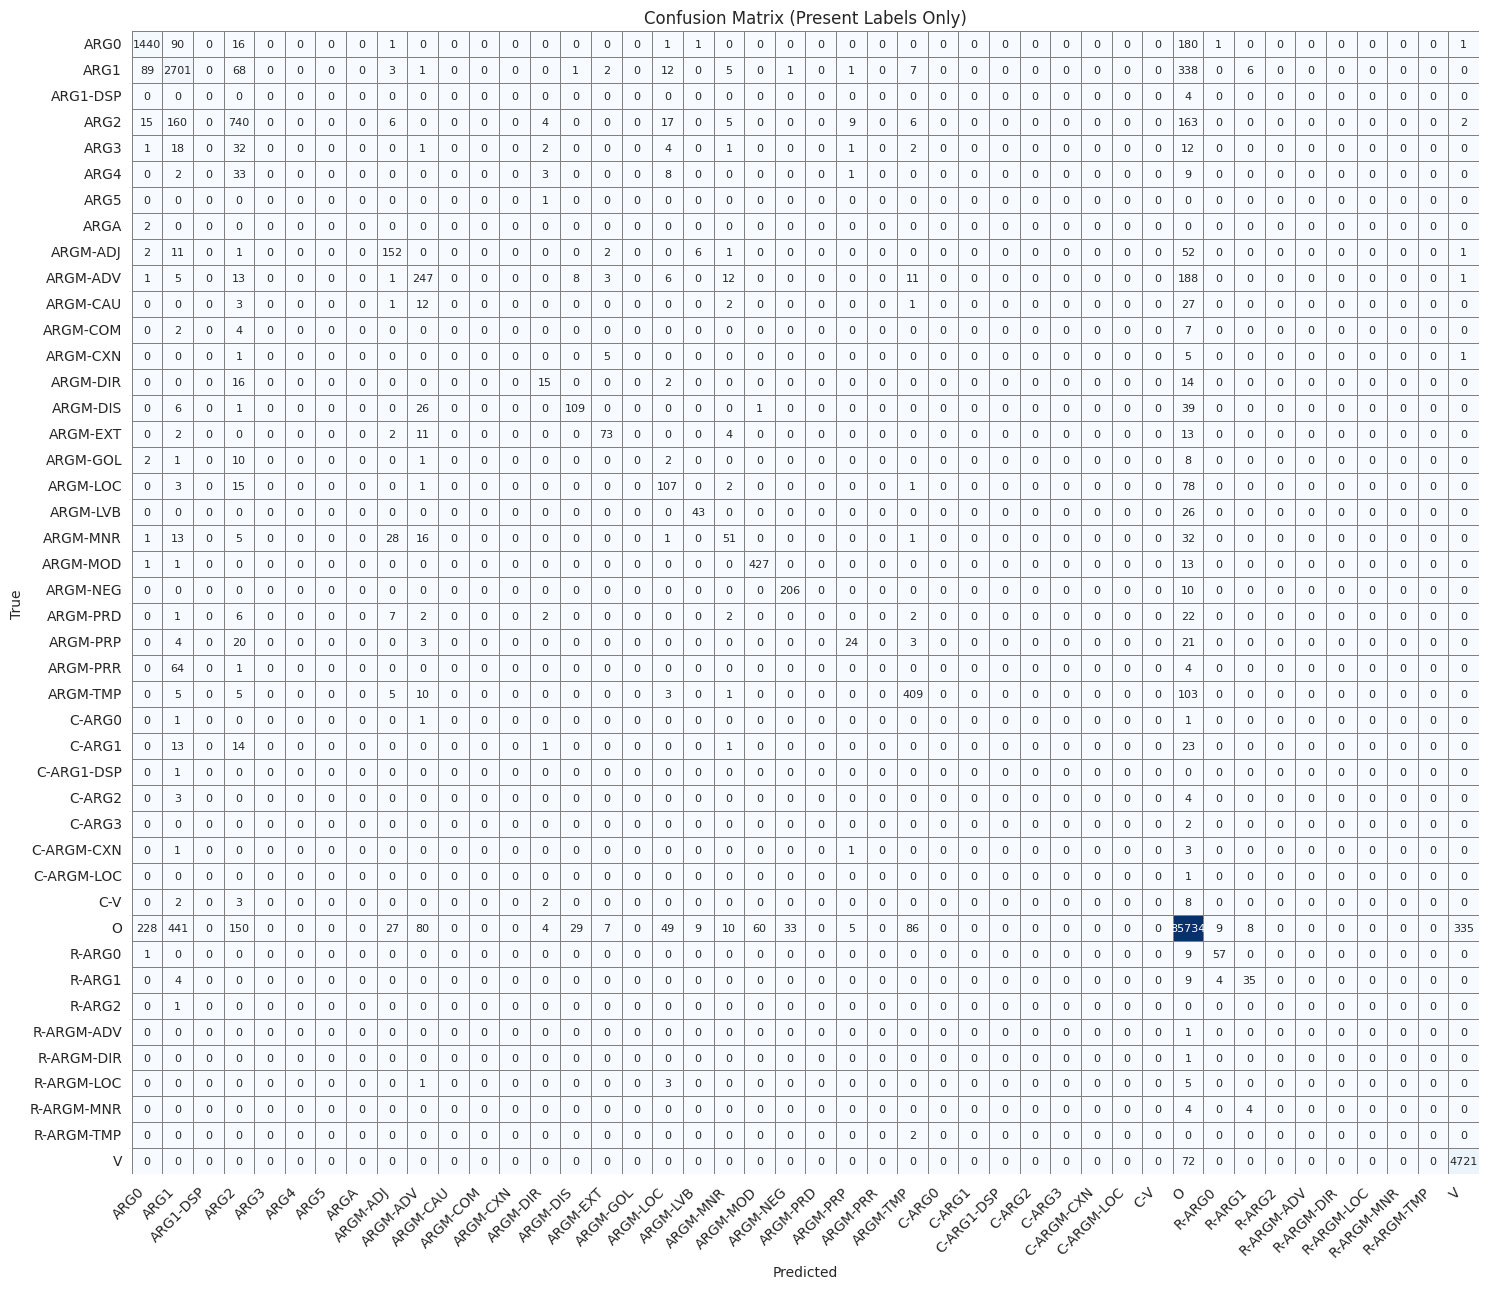

In [151]:
# Generate confusion matrix
plt.figure(figsize=(15, 13))
cm = confusion_matrix(flat_labels, flat_preds, labels=filtered_label_list)

# Create DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=filtered_label_list, columns=filtered_label_list)

# Plot heatmap
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=filtered_label_list,
            yticklabels=filtered_label_list,
            cmap='Blues',
            cbar=False,
            annot_kws={"size": 8},
            linewidths=0.5,
            linecolor="grey")
plt.title("Confusion Matrix (Present Labels Only)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 6. Evaluation

#### Overall Performance:

The model achieves an overall accuracy of 0.9584, though this is heavily influenced by the dominant 'O' class (no argument), which accounts for 87,304 out of 101,518 tokens (86%). The macro average F1-score of 0.3014 versus the weighted average F1-score of 0.9561 reveals a significant performance disparity between frequent and rare classes. While the model excels at predicting common labels ('O', core arguments, and frequent modifiers), it struggles substantially with less common semantic roles.

#### Performance by Class:


##### High-performing Classes:
The model shows exceptional performance on:

    The 'O' class (F1=0.9823), demonstrating near-perfect identification of non-argument tokens

    Core verb identification ('V' with F1=0.9581)

    Core arguments: 'ARG0' (F1=0.8196) and 'ARG1' (F1=0.7955)

    Key modifiers: 'ARGM-MOD' (F1=0.9183), 'ARGM-NEG' (F1=0.9035), and 'ARGM-TMP' (F1=0.7631)


##### Moderate-performing Classes: 

Several classes show acceptable but imperfect performance:

    'ARG2' (F1=0.6480)

    'ARGM-ADJ' (F1=0.6594)

    'ARGM-EXT' (F1=0.7411)

    'ARGM-DIS' (F1=0.6626)
    

##### Low-performing Classes:

The model completely fails to predict (F1=0.00) numerous rare classes including:

    All numbered arguments beyond ARG4 ('ARG5')

    Most complex arguments ('ARGA', 'ARGM-CAU', 'ARGM-COM')

    Nearly all continuation ('C-') and reference ('R-') arguments

    Many spatial/temporal modifiers ('ARGM-DIR', 'ARGM-GOL')
    

The performance pattern suggests the model handles basic predicate-argument structure well. However, the performance degrades for more complex or subtle semantic roles. Rare classes like the ones who have less than 100 examples are essentially unpredicted. This shows a clear need for either more training data for rare classes or to apply class balancing techniques

In [181]:
# Save results to files
report = classification_report(
    flat_labels,
    flat_preds,
    target_names=filtered_label_list,
    output_dict=True,
    digits=4,
    zero_division=0
)

# Convert to DataFrame and save
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('srl_classification_report.tsv', sep="\t")

# Save confusion matrix
cm_df.to_csv('srl_confusion_matrix.tsv', sep="\t")

print("\nSaved results to:")
print("- srl_classification_report.tsv")
print("- srl_confusion_matrix.tsv")


Saved results to:
- srl_classification_report.tsv
- srl_confusion_matrix.tsv


In [153]:
# Get all possible labels from your label list
all_labels = set(label_list)

# Get labels that actually appeared in predictions or ground truth
present_labels = set(flat_labels + flat_preds)

# Find labels that were filtered out
filtered_out_labels = sorted(all_labels - present_labels)

# Print results
print(f"Total labels in label_list: {len(all_labels)}")
print(f"Labels actually present: {len(present_labels)}")
print(f"\nLabels filtered out ({len(filtered_out_labels)}):")
for i, label in enumerate(filtered_out_labels, 1):
    print(f"{i}. {label}")

Total labels in label_list: 60
Labels actually present: 44

Labels filtered out (16):
1. ARGM-REC
2. C-ARG4
3. C-ARGM-ADV
4. C-ARGM-COM
5. C-ARGM-DIR
6. C-ARGM-EXT
7. C-ARGM-GOL
8. C-ARGM-MNR
9. C-ARGM-PRP
10. C-ARGM-PRR
11. C-ARGM-TMP
12. R-ARG3
13. R-ARG4
14. R-ARGM-CAU
15. R-ARGM-COM
16. R-ARGM-GOL


### 7. Saving predictions to a file

In [155]:
import csv

def save_predictions_to_tsv(dataset, word_level_preds, word_level_labels, output_file="predictions.tsv"):
    """
    Saves predictions in TSV format with columns: token, gold_label, predicted_label
    
    Args:
        dataset: Original dataset containing "words" for each example
        word_level_preds: List of predicted labels for each token
        word_level_labels: List of gold labels for each token
        output_file: Path to save the TSV file
    """
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f, delimiter='\t')
        
        # Write header
        writer.writerow(['token', 'gold_label', 'predicted_label'])
        
        # Write each token with its labels
        for words, golds, preds in zip(dataset['words'], word_level_labels, word_level_preds):
            for word, gold, pred in zip(words, golds, preds):
                writer.writerow([word, gold, pred])
    
    print(f"Predictions saved to {output_file}")

# Usage:
save_predictions_to_tsv(
    dataset_dict["test"],
    word_level_preds,
    word_level_labels,
    "predictions.tsv"
)

Predictions saved to predictions.tsv


## 8. Creating an inference function

In [168]:
import torch
def perform_srl(sentence, predicate_mask, model, tokenizer, label_list):
    """
    Returns SRL roles for all tokens, maintaining original sentence indices.
    
    Args:
        sentence: List[str] - Tokenized words
        predicate_mask: List[int] - Binary mask with exactly one 1
        model: Fine-tuned SRL model
        tokenizer: Model's tokenizer
        label_list: List[str] - All SRL labels
        
    Returns:
        List[str] - Roles for each token (including 'O' and predicate)
        Example: ['O', 'ARG0', 'V', 'O', 'ARG1', 'ARGM-LOC', 'O']
    """
    # Validate single predicate
    if sum(predicate_mask) != 1:
        raise ValueError("Must specify exactly one predicate")
    
    # Prepare input
    predicate_idx = predicate_mask.index(1)
    inputs = tokenizer(
        sentence,
        [sentence[predicate_idx]],
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True
    )
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = np.argmax(outputs.logits.cpu().numpy(), axis=2)[0]
    
    # Initialize with 'O' as default
    roles = ['O'] * len(sentence)
    word_ids = inputs.word_ids(0)
    current_word = None
    
    for token_idx, word_id in enumerate(word_ids):
        if word_id is None or word_id == current_word:
            continue
            
        current_word = word_id
        roles[word_id] = label_list[predictions[token_idx]]
    
    return roles


In [169]:
model_path = "model"
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
loaded_model = AutoModelForTokenClassification.from_pretrained(model_path)

sentence = ["The", "dog", "chased", "the", "ball", "in", "the", "park", "."]
predicate_mask = [0, 0, 1, 0, 0, 0, 0, 0, 0]

arguments = perform_srl(sentence, predicate_mask, model, tokenizer, label_list)
print("Argument roles:", arguments)

Argument roles: ['O', 'ARG0', 'V', 'O', 'ARG1', 'O', 'O', 'ARGM-LOC', 'O']
